In [1]:
import pycbc.noise
import pycbc.psd
import numpy as np
import pylab as pl

In [2]:
flow = 10.0
delta_f = 1.0 / 16
flen = int(2048 / delta_f) + 1
psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)

In [3]:
delta_t = 1.0 / 4096
tsamples = int(16 / delta_t)
strain = pycbc.noise.noise_from_psd(tsamples, delta_t, psd, seed=127)
stilde = strain.to_frequencyseries()

In [5]:
strain.data

array([ 8.75332757e-22,  1.27597257e-22,  1.88838814e-22, ...,
        2.64440486e-22, -2.04156416e-22,  4.65732154e-22])

In [4]:
stilde.data

array([ 5.24973292e-24+0.00000000e+00j,  5.25360827e-24+1.15163089e-26j,
        5.25060166e-24+2.31395214e-26j, ...,
        3.14916700e-23+1.02516391e-23j, -3.98632963e-24+1.39346433e-23j,
        5.95962558e-24+0.00000000e+00j])

In [6]:
freqs = np.arange(10, 2000, 0.1)
s = []
for f in freqs:
    s.append(stilde.at_frequency(f))


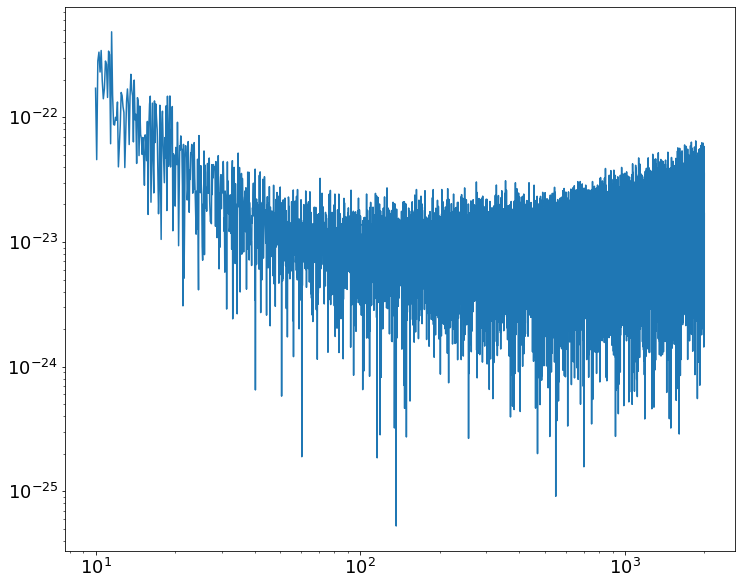

In [7]:
pl.rcParams.update({'font.size': 18})
pl.figure(figsize=(12,10))
pl.loglog(freqs, np.abs(s))

In [ ]:
pl.plot(strain.data)

In [ ]:
from scipy import fft

In [ ]:
t = np.linspace(0, 10, 2000, endpoint=True)
f0 = 30
f1 = 40
f2 = 50
ts = 10*np.sin(2*np.pi*f0*t) + 5*np.sin(2*np.pi*f1*t) + 2*np.sin(2*np.pi*f2*t)
fs = fft.fft(ts)
f = fft.fftfreq(len(t), np.mean(np.diff(t)))

pl.rcParams.update({'font.size': 18})
pl.figure(figsize=(20,10))
pl.subplot(2,1,1)
pl.plot(t, ts)
pl.xlabel('time')
pl.ylabel('amplitude')
pl.subplot(2,1,2)
pl.plot(f, np.abs(fs))
pl.xlabel('frequency')
pl.xlim([0, np.max(f)])

In [ ]:
t = np.linspace(0, 10, 2000, endpoint=True)

ts = 10*np.sin(2*np.pi*f0*t)*np.exp(-t/10)
fs = fft.fft(ts)
f = fft.fftfreq(len(t), np.mean(np.diff(t)))

pl.rcParams.update({'font.size': 18})
pl.figure(figsize=(20,10))
pl.subplot(2,1,1)
pl.plot(t, ts)
pl.xlabel('time')
pl.ylabel('amplitude')
pl.subplot(2,1,2)
pl.plot(f, np.abs(fs))
pl.xlabel('frequency')
pl.xlim([0, np.max(f)])

In [ ]:
t = np.linspace(0, 10, 2000, endpoint=True)

for scale in range(100, 0, -1):
    print(scale)
    ts = 10*np.sin(2*np.pi*f0*t)*np.exp(-t/10) + scale*np.random.random(len(t))
    fs = fft.fft(ts)
    f = fft.fftfreq(len(t), np.mean(np.diff(t)))

    pl.clf()
    pl.rcParams.update({'font.size': 18})
    pl.figure(figsize=(20,10))
    pl.subplot(2,1,1)
    pl.plot(t, ts)
    pl.xlabel('time')
    pl.ylabel('amplitude')
    pl.title('Noise is {} times the signal amplitude'.format(scale))
    pl.subplot(2,1,2)
    pl.plot(f, np.abs(fs))
    pl.xlabel('frequency')
    pl.xlim([0, np.max(f)])
    num = "{:03d}".format(scale)
    pl.savefig('figures/fft_{}.png'.format(num))

### Creating a CBC waveform

In [9]:
import pycbc.waveform

In [ ]:
hp1, hc1 = pycbc.waveform.get_fd_waveform(approximant="IMRPhenomD",
                                          mass1=10, mass2=10, distance=100,
                                          f_lower=flow, delta_f=stilde.delta_f)
hp2, hc2 = pycbc.waveform.get_fd_waveform(approximant="IMRPhenomD",
                                          mass1=1.4, mass2=1.4, distance=100,
                                          f_lower=flow, delta_f=stilde.delta_f)
hp3, hc3 = pycbc.waveform.get_fd_waveform(approximant="IMRPhenomD",
                                          mass1=10, mass2=1.4, distance=100,
                                          f_lower=flow, delta_f=stilde.delta_f)

In [ ]:
htilde1 = hp1.to_frequencyseries()
htilde2 = hp2.to_frequencyseries()
htilde3 = hp3.to_frequencyseries()

In [ ]:
freqs = np.arange(10, 2000, 0.1)
hf1 = []
hf2 = []
hf3 = []
for f in freqs:
    hf1.append(htilde1.at_frequency(f))
    hf2.append(htilde2.at_frequency(f))    
    hf3.append(htilde3.at_frequency(f))        

In [ ]:
pl.rcParams.update({'font.size': 18})
pl.figure(figsize=(12,10))
pl.loglog(freqs, np.abs(s), alpha=0.4)
pl.loglog(freqs, np.abs(hf1), 'r-', linewidth=2, label='BBH')
pl.loglog(freqs, np.abs(hf2), 'g-', linewidth=2, label='BNS')
pl.loglog(freqs, np.abs(hf3), 'k-', linewidth=2, label='NSBH')
pl.legend()

In [90]:
hp, hc = pycbc.waveform.get_td_waveform(approximant="SpinTaylorT4",
                                        mass1=25, mass2=20, distance=500,
                                        f_lower=flow, delta_t=delta_t)

In [110]:
import pycbc.detector

In [111]:
D = pycbc.detector.Detector("H1")

In [112]:
F_plus, F_cross = D.antenna_pattern(0, 0, 0, 800000000)

In [126]:
Times = np.arange(0, -len(hp)*hp.delta_t, -hp.delta_t)
h = []
for t in Times:
    this_hp = hp.at_time(t)
    this_hc = hc.at_time(t)
    h.append(F_plus*this_hp.data + F_cross*this_hc.data)
h = np.array(h)

In [122]:
h = np.append(h, np.zeros(len(strain) - len(h)))

<Figure size 432x288 with 0 Axes>

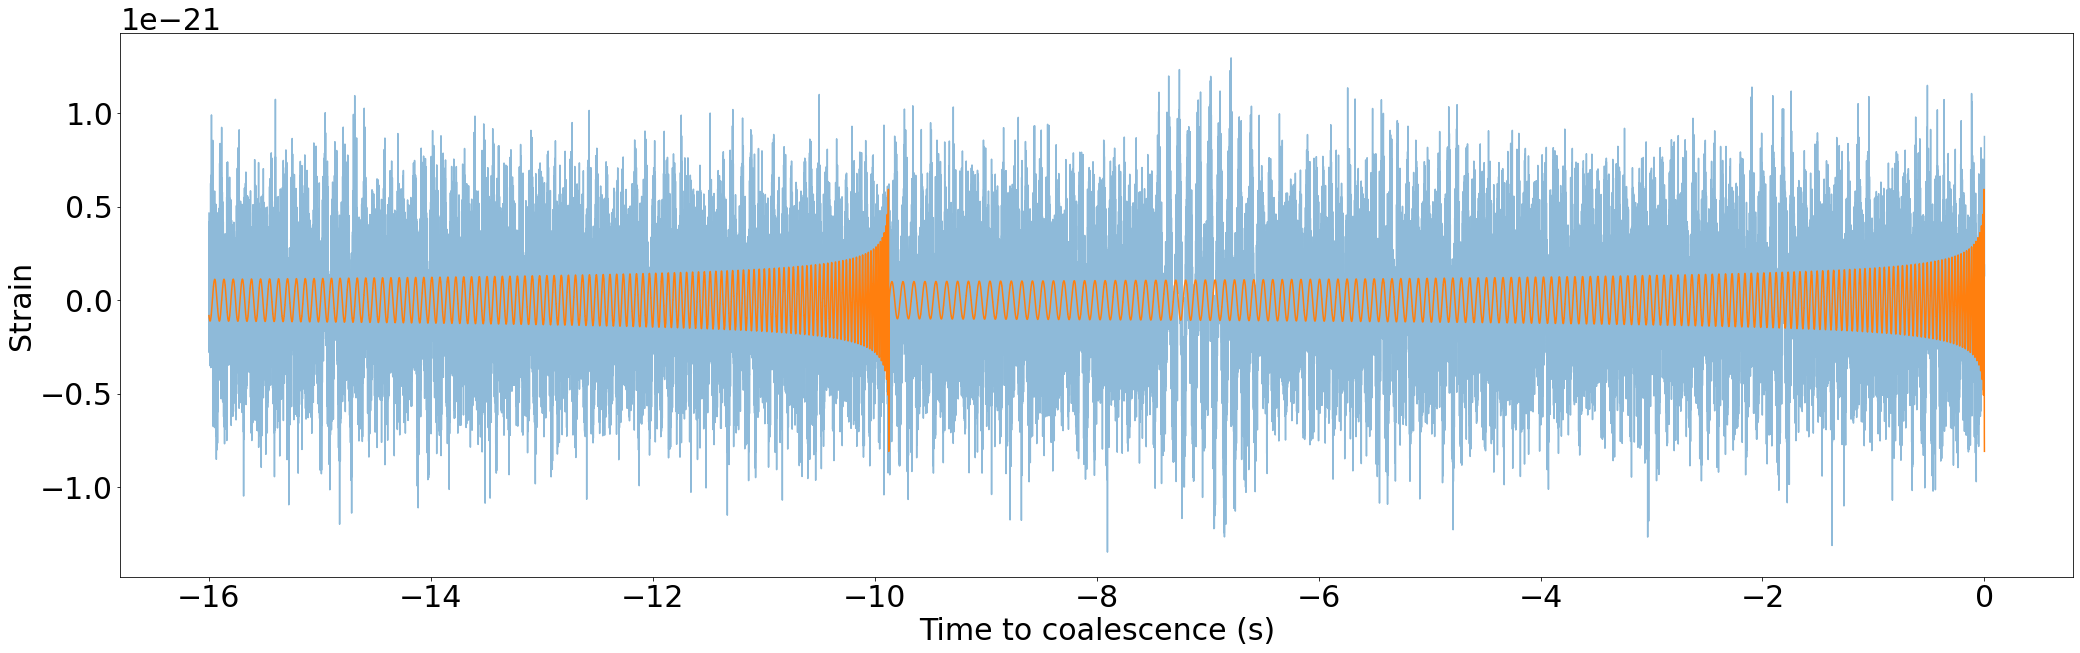

In [125]:
pl.clf()
pl.rcParams.update({'font.size': 30})
pl.figure(figsize=(35,10))
pl.xlabel('Time to coalescence (s)')
pl.ylabel('Strain')
pl.plot(Times, strain, alpha=0.5)
pl.plot(Times, h)

In [106]:
hptilde = hp.to_frequencyseries(delta_f=stilde.delta_f)
hptilde.resize(len(stilde))
snr = pycbc.filter.matched_filter(hptilde, stilde, psd=psd,
                                  low_frequency_cutoff=flow)


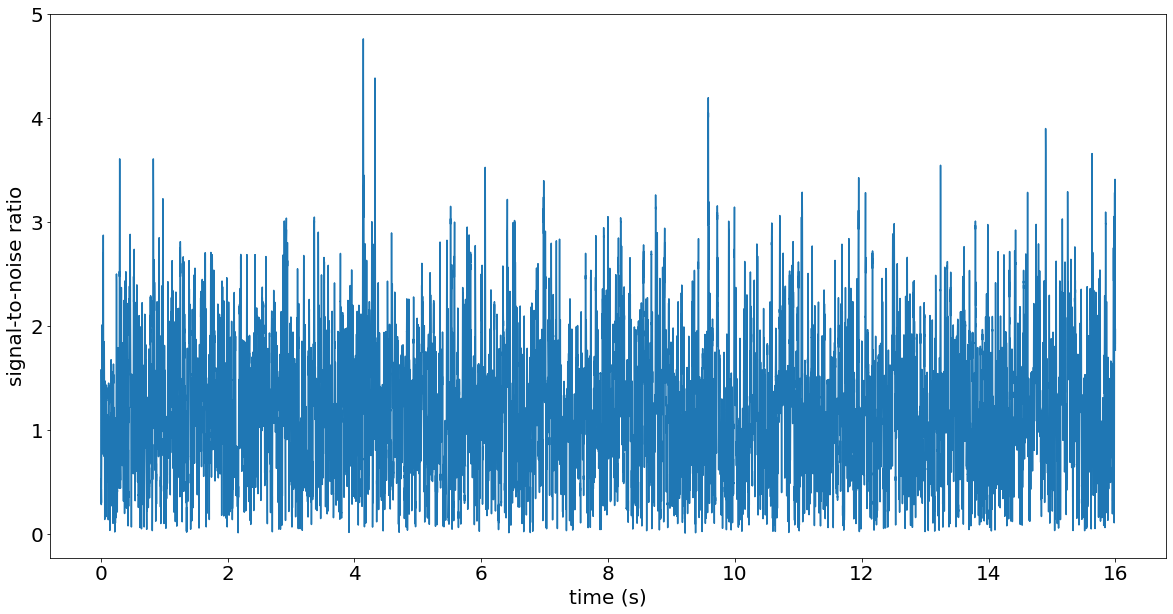

In [109]:
pl.rcParams.update({'font.size': 20})
pl.figure(figsize=(20,10))
pl.plot(snr.sample_times, abs(snr))
pl.ylabel('signal-to-noise ratio')
pl.xlabel('time (s)')
pl.show()